In [2]:
from PIL import Image
from model import AggMInterface
from data import DInterface
import yaml
import warnings
warnings.filterwarnings("ignore")

# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_1/hparams.yaml"
checkpoint_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_1/checkpoints/dinov2_backbone_epoch(15)_step(15632)_R1[0.8946]_R5[0.9554]_R10[0.9608].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path) as f:
    config = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module = DInterface(**config)  # 数据模块初始化，传入配置参数
transform = data_module.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()

正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


AggMInterface(
  (model): Dinov2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features

特征的初始形状: torch.Size([1, 16, 1601, 1601])
调整后的特征形状: torch.Size([1, 16, 1600])
重塑后的特征形状: torch.Size([1, 16, 40, 40])


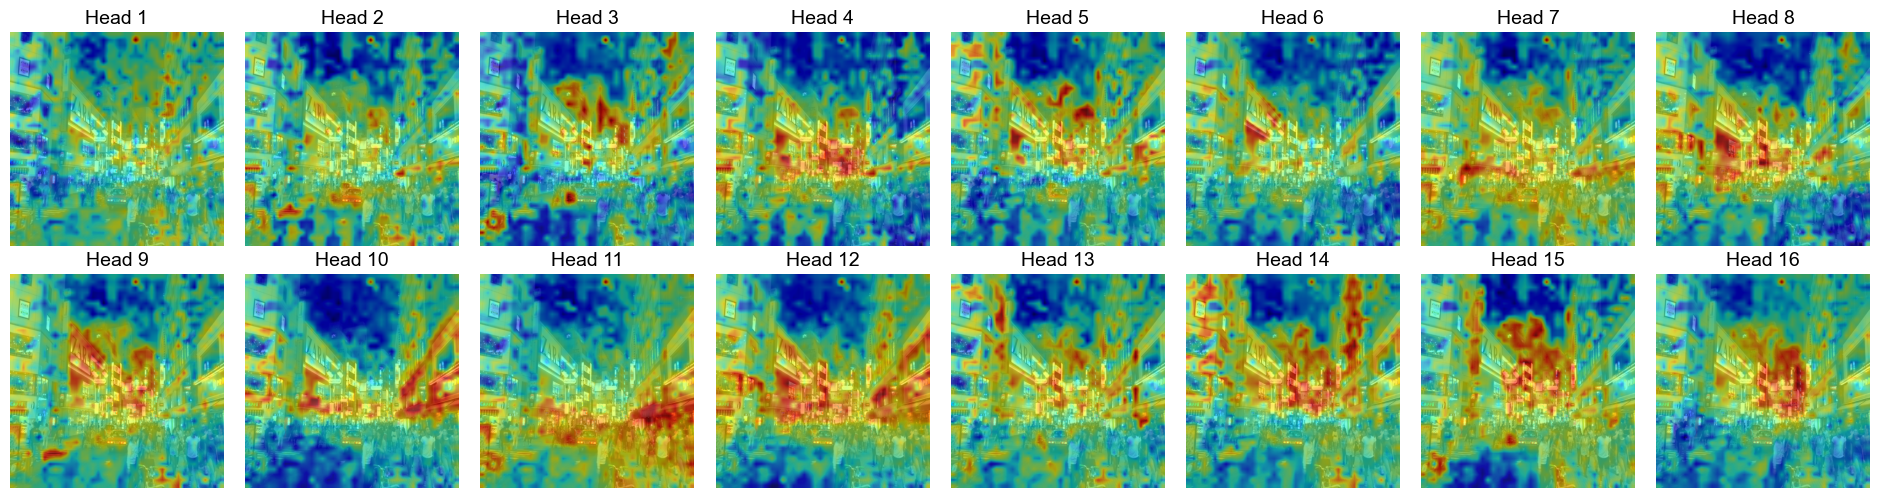

In [3]:
from utils.hook_func import extract_features
from visualization.visualization_multi_head import visualize_multi_head_attention

# 获取指定图像的特征
image_path = r"/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/tmp_imgs/00177.jpg"
image = Image.open(image_path).convert("RGB")
# 应用数据变换并将图像转移到GPU
image = transform(image).unsqueeze(0).cuda()

# 为模型注册hook以提取特征
block_idx = [23]
facet = 'attn'
facet_layer_and_facet = {23: 'attn'}
feats = extract_features(model.model.model, image, facet_layer_and_facet)
# 提取特征的形状信息
b, h, t, t = feats[0].shape
print(f"特征的初始形状: {feats[0].shape}")
# 调整特征的形状以适应可视化
feats = feats[0][:,:,0,1:]
b, h, t = feats.shape
print(f"调整后的特征形状: {feats.shape}")
# 计算特征的平方根以重塑为矩阵
n, m = int(t**0.5), int(t**0.5)
feats = feats.reshape(b,h,n,m).detach().cpu()
print(f"重塑后的特征形状: {feats.shape}")

# 可视化多头注意力
visualize_multi_head_attention(
    attentions=feats,
    original_size=(560,560),
    image_path=image_path,
    save_path=None,
    alpha=0.6,
    heads_per_row=8,
    head_size=3.0,
    wspace=0.1,
    dpi=100,
    font_family='Arial',
    title_fontsize=14
)

显著性图的形状: torch.Size([1, 1600])


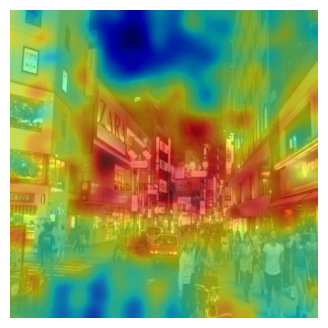

In [7]:
from utils.hook_func import extract_saliency_maps
from visualization import visualize_saliency_maps

facet_layer_and_facet = {23: 'attn'}
saliency_map = extract_saliency_maps(model.model.model, facet_layer_and_facet, image)
print(f"显著性图的形状: {saliency_map.shape}")
saliency_map = saliency_map[0].detach().cpu()
visualize_saliency_maps(
    image=image,
    saliency_map=saliency_map,
    alpha=0.6,
    cmap='jet',
    save_path=None,
    figsize=(4,4),
    sigma=1.0
)